In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/figshare-brain-tumor-dataset/dataset/README.txt
/kaggle/input/figshare-brain-tumor-dataset/dataset/cvind.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/2912.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/2011.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/3027.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/1912.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/3023.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/101.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/1194.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/851.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/2106.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/1850.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/2911.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/1731.mat
/kaggle/input/figshare-brain-tumor-dataset/dataset/data/1014.mat
/kaggle/input/figshare-brain-tumor

In [2]:
import os
import PIL
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2

In [3]:
os.mkdir("/kaggle/working/bt_images")
os.mkdir("/kaggle/working/bt_images/1")
os.mkdir("/kaggle/working/bt_images/2")
os.mkdir("/kaggle/working/bt_images/3")

3064 files successfully saved


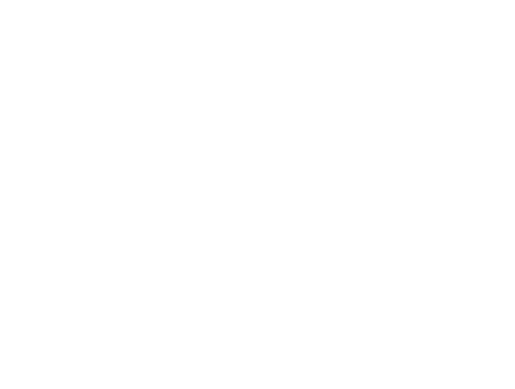

In [4]:
labels=[]
border=[]
filename = None

for filename in range(1, 3065):
  with h5py.File('/kaggle/input/figshare-brain-tumor-dataset/dataset/data/{}.mat'.format(filename), 'r') as f:
      img = f['cjdata']['image']
      label = f['cjdata']['label'][0][0]
     
     
      labels.append(int(label))
      img = np.array(img, dtype=np.float32)
      
      plt.axis('off')
      
      plt.imsave("/kaggle/working/bt_images/{}/{}.jpg".format(str(int(label)),filename), img, cmap='gray')
      
      
print("{} files successfully saved".format(filename))

In [5]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/kaggle/working/bt_images', output="/kaggle/working/output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 3064 files [00:00, 6223.39 files/s]


In [6]:
#packages for notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.datasets import ImageFolder

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
#os.rmdir('/kaggle/working/output/train/0')
# os.rmdir('/kaggle/working/output/val/0')

In [9]:
dataset_path="/kaggle/working/output"
batch_size=64
train_dataset = ImageFolder(dataset_path+"/train", transform=transform)
val_dataset = ImageFolder(dataset_path+"/val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all parameters as not trainable
for param in resnet_model.parameters():
    param.requires_grad = False

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer / head for our classification problem
resnet_model.fc = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4)  # Assuming 4 classes
)

# Make only the last 2 layers (fc layer and the final activation) trainable
for name, child in resnet_model.named_children():
    if name == 'fc'or name=='layer4':
        for param in child.parameters():
            param.requires_grad = True

# set model to run on GPU or CPU based on availability (not shown in your code)
resnet_model.cuda()
# print the transfer
print(resnet_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch [1/50], Train Loss: 50.3253, Train Acc: 0.3641, Val Loss: 1.2640, Val Acc: 0.3049
Epoch [2/50], Train Loss: 2.1455, Train Acc: 0.3935, Val Loss: 0.9280, Val Acc: 0.4984
Epoch [3/50], Train Loss: 1.6411, Train Acc: 0.5559, Val Loss: 1.2391, Val Acc: 0.6852
Epoch [4/50], Train Loss: 1.1676, Train Acc: 0.7151, Val Loss: 1.5644, Val Acc: 0.7410
Epoch [5/50], Train Loss: 0.9619, Train Acc: 0.7763, Val Loss: 1.0647, Val Acc: 0.7279
Epoch [6/50], Train Loss: 0.9997, Train Acc: 0.7992, Val Loss: 0.6000, Val Acc: 0.8459
Epoch [7/50], Train Loss: 0.5916, Train Acc: 0.8653, Val Loss: 0.7353, Val Acc: 0.8787
Epoch [8/50], Train Loss: 0.7287, Train Acc: 0.8473, Val Loss: 2.2909, Val Acc: 0.6787
Epoch [9/50], Train Loss: 0.7041, Train Acc: 0.8543, Val Loss: 0.8838, Val Acc: 0.8000
Epoch [10/50], Train Loss: 0.5680, Train Acc: 0.8751, Val Loss: 0.7980, Val Acc: 0.8656
Epoch [11/50], Train Loss: 0.5471, Train Acc: 0.8967, Val Loss: 0.9594, Val Acc: 0.8098
Epoch [12/50], Train Loss: 0.3475, Train

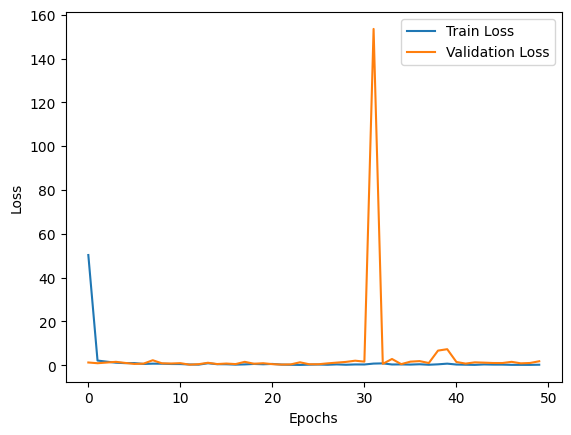

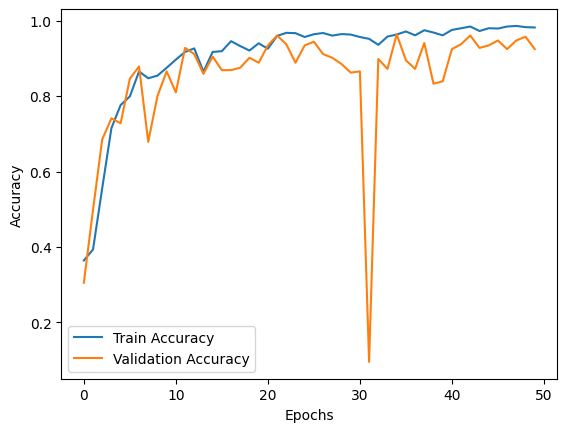

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.01)

# Function to calculate accuracy
def get_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

# Training the model
num_epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in train_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        labels = labels.cuda() if torch.cuda.is_available() else labels

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (torch.argmax(outputs, 1) == labels).sum().item()

    train_acc = correct_train / total_train
    train_accs.append(train_acc)
    train_losses.append(running_loss / len(train_loader))

    # Evaluating on validation set
    resnet_model.eval()
    val_loss = 0.0
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            total_val += labels.size(0)
            correct_val += (torch.argmax(outputs, 1) == labels).sum().item()

    val_acc = correct_val / total_val
    val_accs.append(val_acc)
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')

# Plotting the training process
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()